In [5]:
import pandas as pd
import seaborn as sns
import numpy as np
from scipy.optimize import minimize
from scipy.optimize import minimize_scalar
%matplotlib inline
import matplotlib.pyplot as plt
from rtree import index

#import models
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
# import lightgbm as lgb
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel, ConstantKernel, RBF
#from xgboost import XGBRegressor

from sklearn import model_selection
from sklearn.metrics import explained_variance_score
# from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error
from tabulate import _table_formats, tabulate
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
import pygad
import time
import datetime

from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from joblib import parallel_backend
import mkl
# mkl.set_num_threads(4)

In [10]:
# datas = '../MyData.xlsx'

datas = './MyData.xlsx'

# datas = '/Users/pkrok/OneDrive/Python/Giannakopoulos/MyData.xlsx'

# datas = "/Users/panagiotiskrokidas/OneDrive/Python/Giannakopoulos/MyData.xlsx"

In [11]:
pd.set_option("display.max_columns", None)
df=pd.read_excel(datas)
df.head(2)
df['logD'] = np.log10(df['diffusivity'])
# df = df.dropna()
df[df.gas == 'propylene']['logD'].max()
df[df.gas == 'ethylene']['logD'].count()

71

In [12]:
# df=df[df.gas != 'iso-butane']

# Keep only the columns I need

In [13]:
# df2=df[[ 'aperture', 'size - van der Waals (Å)','mass', 'ascentricF', 'logD', 'size - kinetic diameter (Å)', 'gas', 'apertureAtom_e', 'ionicRad']]
df2=df[[ 'type', 'gas', 'MetalNum', 'aperture', 'size - van der Waals (Å)','mass', 'ascentricF', 'logD', 'size - kinetic diameter (Å)', 'ionicRad', 
       'Μ-N_lff', 'Μ-N_kFF', 'MetalCharge', 'MetalMass',
       'σ_1', 'e_1', 'σ_2', 'e_2', 'σ_3', 'e_3', 'linker_length1', 'linker_length2',
       'linker_length3', 'linker_mass1', 'linker_mass2', 'linker_mass3',
       'func1_length', 'func2_length', 'func3_length', 'func1_mass',  
       'func2_mass', 'func3_mass', 'func1_charge', 'func2_charge',
       'func3_charge',]]

In [14]:
df2=df2.rename(columns={'size - van der Waals (Å)':'diameter', 'size - kinetic diameter (Å)':'kdiameter' })

In [15]:
df2 = df2.dropna()
df2=df2.reset_index(drop=True)
# df2

## CO2 dataframe

In [16]:

df2=df2[
(df2['gas'] != 'isobutane') & (df2['gas'] != 'iso-butane') &
 (df2['gas'] != 'SF6')
# & (df2['gas'] != 'He')
# & (df2['gas'] != 'H2')
# & (df2['gas'] != 'Rn')
].reset_index()

In [17]:
PE_conditions = [
    (df2['gas']=='He'),
    (df2['gas']=='H2'),
    (df2['gas']=='O2'),
    (df2['gas']=='CO2'),
    (df2['gas']=='N2'),
    (df2['gas']=='CH4'),
    (df2['gas']=='NO2'),
    (df2['gas']=='SO2'),
    (df2['gas']=='ethylene'),
    (df2['gas']=='ethane'),
    (df2['gas']=='propylene'),
    (df2['gas']=='propane'),
    (df2['gas']=='butane'),
    (df2['gas']=='Kr'),
    (df2['gas']=='Xe'),
    (df2['gas']=='Rn')]

vertical_values = [0.132, 0.148, 0.151, 0.13785, 0.1655,0.1865, 0.3551, 0.40354,  0.18375,0.1875,0.45134,0.46887,0.46887,0.1845,0.205,0.2085]
long_values = [0.132,0.148,0.423,0.67315,0.441,0.373, 0.67617, 0.72906,  0.5005,0.529,0.805922757,0.830810535,1.354965802,0.369,0.41,0.417,]

df2['vertical'] = np.select(PE_conditions, vertical_values)
df2['long'] = np.select(PE_conditions, long_values)

df2

,index,type,gas,MetalNum,aperture,diameter,mass,ascentricF,logD,kdiameter,ionicRad,Μ-N_lff,Μ-N_kFF,MetalCharge,MetalMass,σ_1,e_1,σ_2,e_2,σ_3,e_3,linker_length1,linker_length2,linker_length3,linker_mass1,linker_mass2,linker_mass3,func1_length,func2_length,func3_length,func1_mass,func2_mass,func3_mass,func1_charge,func2_charge,func3_charge,vertical,long
0,0,CdIF-1,He,48,3.92,2.66,4.002,-0.390,-7.221849,2.60,92,2.257,45354.60,1.1901,112.411,0.250,0.0627,0.250,0.0627,0.250,0.0627,4.438,4.438,4.438,81.0,81.0,81.0,3.78,3.78,3.78,15.0,15.0,15.0,-0.1001,-0.1001,-0.1001,0.13200,0.132000
1,1,CdIF-1,H2,48,3.92,2.76,2.010,-0.217,-7.301030,2.89,92,2.257,45354.60,1.1901,112.411,0.250,0.0627,0.250,0.0627,0.250,0.0627,4.438,4.438,4.438,81.0,81.0,81.0,3.78,3.78,3.78,15.0,15.0,15.0,-0.1001,-0.1001,-0.1001,0.14800,0.148000
2,2,CdIF-1,O2,48,3.92,2.94,31.999,0.022,-8.000000,3.46,92,2.257,45354.60,1.1901,112.411,0.250,0.0627,0.250,0.0627,0.250,0.0627,4.438,4.438,4.438,81.0,81.0,81.0,3.78,3.78,3.78,15.0,15.0,15.0,-0.1001,-0.1001,-0.1001,0.15100,0.423000
3,3,CdIF-1,CO2,48,3.92,3.24,44.010,0.225,-8.397940,3.30,92,2.257,45354.60,1.1901,112.411,0.250,0.0627,0.250,0.0627,0.250,0.0627,4.438,4.438,4.438,81.0,81.0,81.0,3.78,3.78,3.78,15.0,15.0,15.0,-0.1001,-0.1001,-0.1001,0.13785,0.673150
4,4,CdIF-1,N2,48,3.92,3.13,28.000,0.037,-8.301030,3.64,92,2.257,45354.60,1.1901,112.411,0.250,0.0627,0.250,0.0627,0.250,0.0627,4.438,4.438,4.438,81.0,81.0,81.0,3.78,3.78,3.78,15.0,15.0,15.0,-0.1001,-0.1001,-0.1001,0.16550,0.441000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
984,994,dIm_Mg,propylene,12,2.95,4.03,42.080,0.142,-13.853872,4.50,71,2.139,38994.88,1.9871,24.305,0.367,1.2552,0.367,1.2552,0.367,1.2552,6.410,6.410,6.410,317.8,317.8,317.8,3.78,3.78,3.78,15.0,15.0,15.0,-0.2710,-0.2710,-0.2710,0.45134,0.805923
985,995,dIm_Mg,propane,12,2.95,4.16,44.100,0.152,-17.397940,4.30,71,2.139,38994.88,1.9871,24.305,0.367,1.2552,0.367,1.2552,0.367,1.2552,6.410,6.410,6.410,317.8,317.8,317.8,3.78,3.78,3.78,15.0,15.0,15.0,-0.2710,-0.2710,-0.2710,0.46887,0.830811
986,996,dIm_Mg,Kr,12,2.95,4.00,83.800,0.005,-11.308919,3.69,71,2.139,38994.88,1.9871,24.305,0.367,1.2552,0.367,1.2552,0.367,1.2552,6.410,6.410,6.410,317.8,317.8,317.8,3.78,3.78,3.78,15.0,15.0,15.0,-0.2710,-0.2710,-0.2710,0.18450,0.369000
987,997,dIm_Mg,Xe,12,2.95,4.10,131.290,0.008,-15.924453,4.10,71,2.139,38994.88,1.9871,24.305,0.367,1.2552,0.367,1.2552,0.367,1.2552,6.410,6.410,6.410,317.8,317.8,317.8,3.78,3.78,3.78,15.0,15.0,15.0,-0.2710,-0.2710,-0.2710,0.20500,0.410000


In [18]:
# dfch4=df2[(df2['diameter'] == 3.25)].reset_index()
# dfch4=dfch4.drop(columns=['index'])
# # dfch4
print(df2['logD'].min())
print(df2.shape)

-45.455931955649724
(989, 38)


## ML models

In [19]:
regr = linear_model.LinearRegression()
tree=DecisionTreeRegressor(max_depth=5,random_state=1)
print(regr)

LinearRegression()


# ga_instance.plot_genes()

## Add more descriptors

## Model with only metal, aperture_e, lengths of linker1&3 and functional1&3

In [20]:
x = np.asanyarray(df2[[
    'diameter',
    'mass',
    'ascentricF',
    'kdiameter',
    'ionicRad',
    'MetalNum',
    'MetalMass',
    # 'aperture', 
    # 'Μ-N_lff', 'Μ-N_kFF', 'MetalCharge',
    'σ_1',
    'e_1',
    'σ_2',
    'e_2',
    'σ_3',
    'e_3',
    'linker_length1', 'linker_length2', 'linker_length3',
    'linker_mass1', 'linker_mass2', 'linker_mass3',
    'func1_length', 'func2_length', 'func3_length', 
    'func1_mass', 'func2_mass', 'func3_mass',
    # 'func1_charge', 'func2_charge','func3_charge',
                      ]])

y= np.array(df2[['logD']])

In [21]:
df2 = df2.dropna()
df2=df2.reset_index(drop=True)
# df2[20:30]

Only XGBR and GBR

In [25]:
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import accuracy_score

# param = {}
# lgbModel=lgb(param)

XGBR = XGBRegressor(n_estimators=500, max_depth=5, eta=0.07, subsample=0.75, colsample_bytree=0.7, reg_lambda=0.4, reg_alpha=0.13,
                    # n_jobs=6,
                    nthread=6,
                    random_state=6410
                   )
RF = RandomForestRegressor(n_estimators=600, max_depth=6, random_state=10)
GBR = GradientBoostingRegressor(n_estimators=500, learning_rate=0.2, max_depth=6, random_state=10,loss='squared_error')
NNregr = MLPRegressor(hidden_layer_sizes=(50, 30, 30, 20, 10), solver='lbfgs', random_state=1, max_iter=5000)
tree=DecisionTreeRegressor(max_depth=6,random_state=1)
# regr=LinearRegression()
regr = linear_model.LinearRegression()
# kernel = DotProduct() + WhiteKernel()
# gpr = GaussianProcessRegressor(kernel=kernel, random_state=0)

# Kernel definition
l = 2
sigma_f = 3
sigma_n = 1
kernel = ConstantKernel(constant_value=sigma_f, constant_value_bounds=(1e-2, 1e2)) \
            * RBF(length_scale=l, length_scale_bounds=(1e-2, 1e2))

kernel_2 = ConstantKernel(1.0, (1e-2, 1e3)) * DotProduct(5, (1e-7, 1e3)) * RBF(2, (1e-7, 1e3))
# GP model 
gpr = GaussianProcessRegressor(kernel=kernel, alpha=sigma_n**2, n_restarts_optimizer=10, )
gpr_2 = GaussianProcessRegressor(kernel=kernel_2, n_restarts_optimizer=10, alpha=0.1, normalize_y=True)


# k-fold cross validation
data_y, data_yhat_tree, data_yhat_NN, data_yhat_regr, data_yhat_RF, data_yhat_GBR, data_yhat_XGBR, data_yhat_gpr = list(), list(), list(), list(), list(), list(), list(), list()
kfold = KFold(n_splits=10, shuffle=True, random_state=50)
# enumerate splits
for train_ix, test_ix in kfold.split(x):
    # get data
    train_X, test_X = x[train_ix], x[test_ix]
    train_y, test_y = y[train_ix], y[test_ix]

    XGBR.fit(train_X, train_y.ravel())
    RF.fit(train_X, train_y.ravel())
    GBR.fit(train_X, train_y.ravel())
    gpr_2.fit(train_X, train_y.ravel())
    NNregr.fit(train_X, train_y.ravel())
    tree.fit(train_X, train_y)
    regr.fit(train_X, train_y)
    
    # make predictions
    yhat_tree = tree.predict(test_X)
    yhat_regr = regr.predict(test_X)
    yhat_XGBR = XGBR.predict(test_X)
    yhat_RF = RF.predict(test_X)
    yhat_GBR = GBR.predict(test_X)
    yhat_gpr = gpr_2.predict(test_X)
    yhat_NNregr = NNregr.predict(test_X)

    # store
    data_y.extend(test_y)
    data_yhat_tree.extend(yhat_tree)
    data_yhat_regr.extend(yhat_regr)
    data_yhat_XGBR.extend(yhat_XGBR)
    data_yhat_RF.extend(yhat_RF)
    data_yhat_GBR.extend(yhat_GBR)
    data_yhat_gpr.extend(yhat_gpr)
    data_yhat_NN.extend(yhat_NNregr)
# evaluate the model

R2_RF = (metrics.r2_score(data_y, data_yhat_RF))
Med_ABS_er_RF = (metrics.median_absolute_error(data_y, data_yhat_RF))
Max_error_RF = (metrics.max_error(data_y, data_yhat_RF))
EV_RF = (metrics.explained_variance_score(data_y, data_yhat_RF))
Mean_abs_perc_error_RF = (metrics.mean_absolute_percentage_error(data_y, data_yhat_RF))
MSE_RF = (metrics.mean_squared_error(data_y, data_yhat_RF))

R2_GBR = (metrics.r2_score(data_y, data_yhat_GBR))
Med_ABS_er_GBR = (metrics.median_absolute_error(data_y, data_yhat_GBR))
Max_error_GBR = (metrics.max_error(data_y, data_yhat_GBR))
EV_GBR = (metrics.explained_variance_score(data_y, data_yhat_GBR))
Mean_abs_perc_error_GBR = (metrics.mean_absolute_percentage_error(data_y, data_yhat_GBR))
MSE_GBR = (metrics.mean_squared_error(data_y, data_yhat_GBR))

R2_XGBR = (metrics.r2_score(data_y, data_yhat_XGBR))
Med_ABS_er_XGBR = (metrics.median_absolute_error(data_y, data_yhat_XGBR))
Max_error_XGBR = (metrics.max_error(data_y, data_yhat_XGBR))
EV_XGBR = (metrics.explained_variance_score(data_y, data_yhat_XGBR))
Mean_abs_perc_error_XGBR = (metrics.mean_absolute_percentage_error(data_y, data_yhat_XGBR))
MSE_XGBR = (metrics.mean_squared_error(data_y, data_yhat_XGBR))

R2_NN = (metrics.r2_score(data_y, data_yhat_NN))
Med_ABS_er_NN = (metrics.median_absolute_error(data_y, data_yhat_NN))
Max_error_NN = (metrics.max_error(data_y, data_yhat_NN))
EV_NN = (explained_variance_score(data_y, data_yhat_NN))
Mean_abs_perc_error_NN = (metrics.mean_absolute_percentage_error(data_y, data_yhat_NN))
MSE_NN = (metrics.mean_squared_error(data_y, data_yhat_NN))

R2_regr = (metrics.r2_score(data_y, data_yhat_regr))
Med_ABS_er_regr = (metrics.median_absolute_error(data_y, data_yhat_regr))
Max_error_regr = (metrics.max_error(data_y, data_yhat_regr))
EV_regr = (metrics.explained_variance_score(data_y, data_yhat_regr))
Mean_abs_perc_error_regr = (metrics.mean_absolute_percentage_error(data_y, data_yhat_regr))
MSE_regr = (metrics.mean_squared_error(data_y, data_yhat_regr))

R2_DT = (metrics.r2_score(data_y, data_yhat_tree))
Med_ABS_er_DT = (metrics.median_absolute_error(data_y, data_yhat_tree))
Max_error_DT = (metrics.max_error(data_y, data_yhat_tree))
EV_DT = (metrics.explained_variance_score(data_y, data_yhat_tree))
Mean_abs_perc_error_DT = (metrics.mean_absolute_percentage_error(data_y, data_yhat_tree))
MSE_DT = (metrics.mean_squared_error(data_y, data_yhat_tree))

R2_gpr = (metrics.r2_score(data_y, data_yhat_gpr))
Med_ABS_er_gpr = (metrics.median_absolute_error(data_y, data_yhat_gpr))
Max_error_gpr = (metrics.max_error(data_y, data_yhat_gpr))
EV_gpr = (metrics.explained_variance_score(data_y, data_yhat_gpr))
Mean_abs_perc_error_gpr = (metrics.mean_absolute_percentage_error(data_y, data_yhat_gpr))
MSE_gpr = (metrics.mean_squared_error(data_y, data_yhat_gpr))

head = ["Model", "R2", "Med ABS error", "Max error", "explained variance", "Mean ABS perc error", "MSE" ]

results = [
           ["Decision tree", R2_DT, Med_ABS_er_DT, Max_error_DT, EV_DT, Mean_abs_perc_error_DT, MSE_DT],
           ["Regression", R2_regr, Med_ABS_er_regr, Max_error_regr, EV_regr, Mean_abs_perc_error_regr, MSE_regr],
           ["Random Forest", R2_RF, Med_ABS_er_RF, Max_error_RF, EV_RF, Mean_abs_perc_error_RF, MSE_RF],
           ["Gradient Tree Boosting", R2_GBR, Med_ABS_er_GBR, Max_error_GBR, EV_GBR, Mean_abs_perc_error_GBR, MSE_GBR],
           ["Extreme Gradient Boosting", R2_XGBR, Med_ABS_er_XGBR, Max_error_XGBR, EV_XGBR, Mean_abs_perc_error_XGBR, MSE_XGBR],
           ["Gaussian Process Regressor", R2_gpr, Med_ABS_er_gpr, Max_error_gpr, EV_gpr, Mean_abs_perc_error_gpr, MSE_gpr],
           ["Neural Network", R2_NN, Med_ABS_er_NN, Max_error_NN, EV_NN, Mean_abs_perc_error_NN, MSE_NN]
          ]

print(tabulate(results, headers = head, tablefmt = "fancy_grid", floatfmt=".3f"))

c:\Users\pkrok\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\pkrok\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\Users\pkrok\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better 

╒════════════════════════════╤════════╤═════════════════╤═════════════╤══════════════════════╤═══════════════════════╤════════╕
│ Model                      │     R2 │   Med ABS error │   Max error │   explained variance │   Mean ABS perc error │    MSE │
╞════════════════════════════╪════════╪═════════════════╪═════════════╪══════════════════════╪═══════════════════════╪════════╡
│ Decision tree              │  0.883 │           0.833 │      10.567 │                0.884 │                 0.086 │  3.873 │
├────────────────────────────┼────────┼─────────────────┼─────────────┼──────────────────────┼───────────────────────┼────────┤
│ Regression                 │  0.763 │           1.739 │      18.962 │                0.763 │                 0.166 │  7.868 │
├────────────────────────────┼────────┼─────────────────┼─────────────┼──────────────────────┼───────────────────────┼────────┤
│ Random Forest              │  0.922 │           0.719 │       6.956 │                0.922 │          

c:\Users\pkrok\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


In [33]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

# XGBR = XGBRegressor(n_estimators=600, max_depth=4, eta=0.23, subsample=0.75, colsample_bytree=0.58, reg_lambda=0.4, reg_alpha=0.13,
#                     # n_jobs=6,
#                     nthread=1,
#                     random_state=610
#                    )

XGBR = XGBRegressor(n_estimators=800, max_depth=5, eta=0.02, subsample=0.75, colsample_bytree=0.3, reg_lambda=0.6, reg_alpha=0.15,
                    # n_jobs=6,
                    nthread=1,
                    random_state=61
                   )

GBR = GradientBoostingRegressor(n_estimators=500, learning_rate=0.4, max_depth=4, random_state=10,loss='squared_error')

# k-fold cross validation
data_y, data_yhat_GBR, data_yhat_XGBR= list(), list(), list()
kfold = KFold(n_splits=10, shuffle=True, random_state=50)
# enumerate splits
for train_ix, test_ix in kfold.split(x):
    # get data
    train_X, test_X = x[train_ix], x[test_ix]
    train_y, test_y = y[train_ix], y[test_ix]

    XGBR.fit(train_X, train_y.ravel())
    GBR.fit(train_X, train_y.ravel())
    
    # make predictions
    yhat_XGBR = XGBR.predict(test_X)
    yhat_GBR = GBR.predict(test_X)

    # store
    data_y.extend(test_y)
    data_yhat_XGBR.extend(yhat_XGBR)
    data_yhat_GBR.extend(yhat_GBR)
# evaluate the model

R2_GBR = (metrics.r2_score(data_y, data_yhat_GBR))
Med_ABS_er_GBR = (metrics.median_absolute_error(data_y, data_yhat_GBR))
Max_error_GBR = (metrics.max_error(data_y, data_yhat_GBR))
EV_GBR = (metrics.explained_variance_score(data_y, data_yhat_GBR))
Mean_abs_perc_error_GBR = (metrics.mean_absolute_percentage_error(data_y, data_yhat_GBR))
MSE_GBR = (metrics.mean_squared_error(data_y, data_yhat_GBR))

R2_XGBR = (metrics.r2_score(data_y, data_yhat_XGBR))
Med_ABS_er_XGBR = (metrics.median_absolute_error(data_y, data_yhat_XGBR))
Max_error_XGBR = (metrics.max_error(data_y, data_yhat_XGBR))
EV_XGBR = (metrics.explained_variance_score(data_y, data_yhat_XGBR))
Mean_abs_perc_error_XGBR = (metrics.mean_absolute_percentage_error(data_y, data_yhat_XGBR))
MSE_XGBR = (metrics.mean_squared_error(data_y, data_yhat_XGBR))


head = ["Model", "R2", "Med ABS error", "Max error", "explained variance", "Mean ABS perc error", "MSE" ]

results = [
           ["Gradient Tree Boosting", R2_GBR, Med_ABS_er_GBR, Max_error_GBR, EV_GBR, Mean_abs_perc_error_GBR, MSE_GBR],
           ["Extreme Gradient Boosting", R2_XGBR, Med_ABS_er_XGBR, Max_error_XGBR, EV_XGBR, Mean_abs_perc_error_XGBR, MSE_XGBR],
          ]

print(tabulate(results, headers = head, tablefmt = "fancy_grid", floatfmt=".3f"))

╒═══════════════════════════╤═══════╤═════════════════╤═════════════╤══════════════════════╤═══════════════════════╤═══════╕
│ Model                     │    R2 │   Med ABS error │   Max error │   explained variance │   Mean ABS perc error │   MSE │
╞═══════════════════════════╪═══════╪═════════════════╪═════════════╪══════════════════════╪═══════════════════════╪═══════╡
│ Gradient Tree Boosting    │ 0.982 │           0.345 │       6.252 │                0.982 │                 0.037 │ 0.609 │
├───────────────────────────┼───────┼─────────────────┼─────────────┼──────────────────────┼───────────────────────┼───────┤
│ Extreme Gradient Boosting │ 0.984 │           0.298 │       6.287 │                0.984 │                 0.033 │ 0.530 │
╘═══════════════════════════╧═══════╧═════════════════╧═════════════╧══════════════════════╧═══════════════════════╧═══════╛


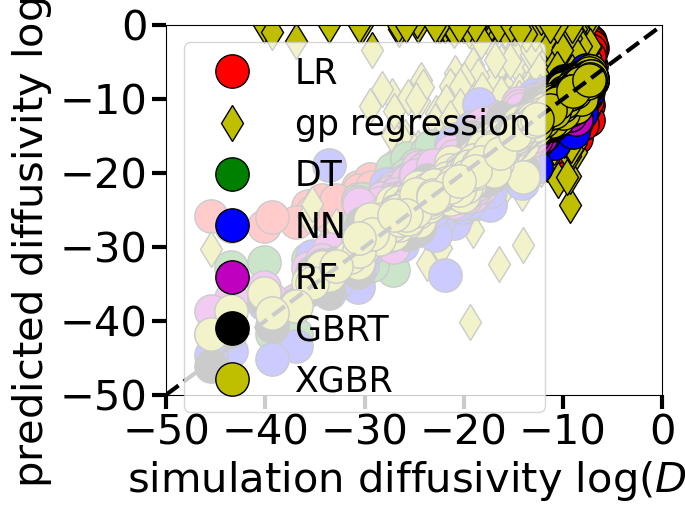

In [22]:
plt.plot(data_y, data_yhat_regr, 'o', label='LR', c='r', markersize='24', linewidth=2, markeredgecolor='k')
plt.plot(data_y, data_yhat_gpr, 'd', label='gp regression', c='y', markersize='18', linewidth=3, markeredgecolor='k')
plt.plot(data_y, data_yhat_tree, 'o', label='DT', c='g', markersize='24', linewidth=2, markeredgecolor='k')
plt.plot(data_y, data_yhat_NN, 'o', label='NN', c='b', markersize='24', linewidth=2, markeredgecolor='k')
plt.plot(data_y, data_yhat_RF, 'o', label='RF', c='m', markersize='24', linewidth=2, markeredgecolor='k')
plt.plot(data_y, data_yhat_GBR, 'o', label='GBRT', c='black', markersize='24', linewidth=2, markeredgecolor='k')
plt.plot(data_y, data_yhat_XGBR, 'o', label='XGBR', c='y', markersize='24', linewidth=2, markeredgecolor='k')


# plt.title ('real vs predicted diffusivity',fontsize=25)
plt.xlabel('simulation diffusivity log($D$)', fontsize=30)
plt.ylabel('predicted diffusivity log($D$)',fontsize=30)
plt.legend(loc='upper left', fontsize=25)

# p1 = max(max(data_y), max(data_y))
# p2 = min(min(data_y), min(data_y))
# plt.plot([p1, p2], [p1, p2],'b-' )
plt.plot([-50, 0], [-50, 0], '--', linewidth=3, color='black')

plt.ylim(-50, 0)
plt.xlim(-50, 0)

plt.tick_params(which='both', width=3)
plt.tick_params(which='major', length=10)
plt.tick_params(which='minor', length=4, color='r')
plt.rcParams["figure.figsize"] = (10,10)
plt.rcParams['axes.linewidth'] = 2

plt.yticks(fontsize=30)
plt.xticks(fontsize=30)

plt.savefig('D_all_models.png', bbox_inches='tight')
plt.show()

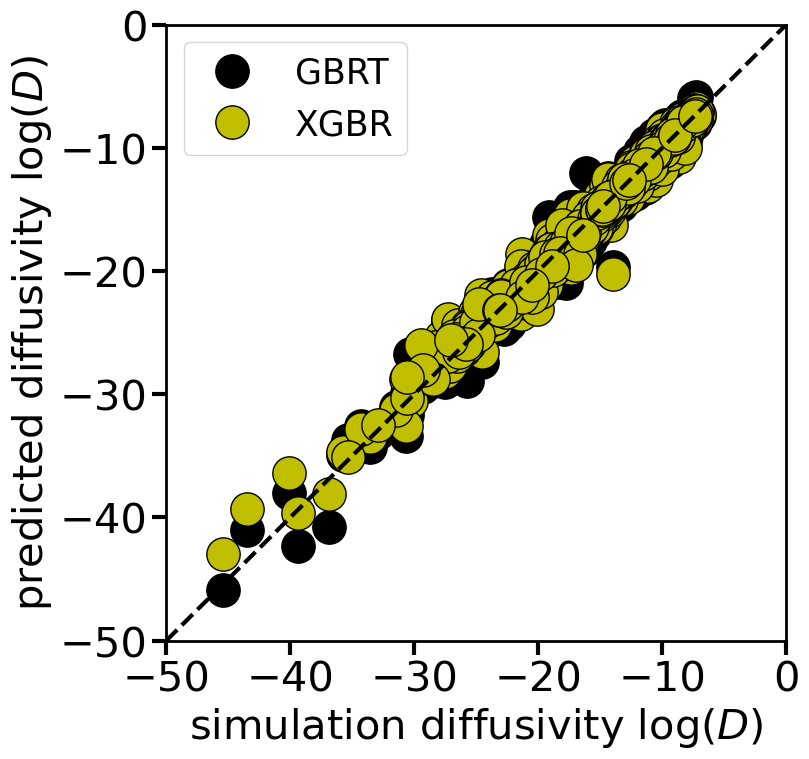

In [27]:
plt.plot(data_y, data_yhat_GBR, 'o', label='GBRT', c='black', markersize='24', linewidth=2, markeredgecolor='k')
plt.plot(data_y, data_yhat_XGBR, 'o', label='XGBR', c='y', markersize='24', linewidth=2, markeredgecolor='k')

# plt.title ('real vs predicted diffusivity',fontsize=25)
plt.xlabel('simulation diffusivity log($D$)', fontsize=30)
plt.ylabel('predicted diffusivity log($D$)',fontsize=30)
plt.legend(loc='upper left', fontsize=25)

# p1 = max(max(data_y), max(data_y))
# p2 = min(min(data_y), min(data_y))
# plt.plot([p1, p2], [p1, p2],'b-' )
plt.plot([-50, 0], [-50, 0], '--', linewidth=3, color='black')

plt.ylim(-50, 0)
plt.xlim(-50, 0)

plt.tick_params(which='both', width=3)
plt.tick_params(which='major', length=10)
plt.tick_params(which='minor', length=4, color='r')
plt.rcParams["figure.figsize"] = (8,8)

plt.yticks(fontsize=30)
plt.xticks(fontsize=30)

plt.savefig('XGBR.png', bbox_inches='tight')
plt.show()

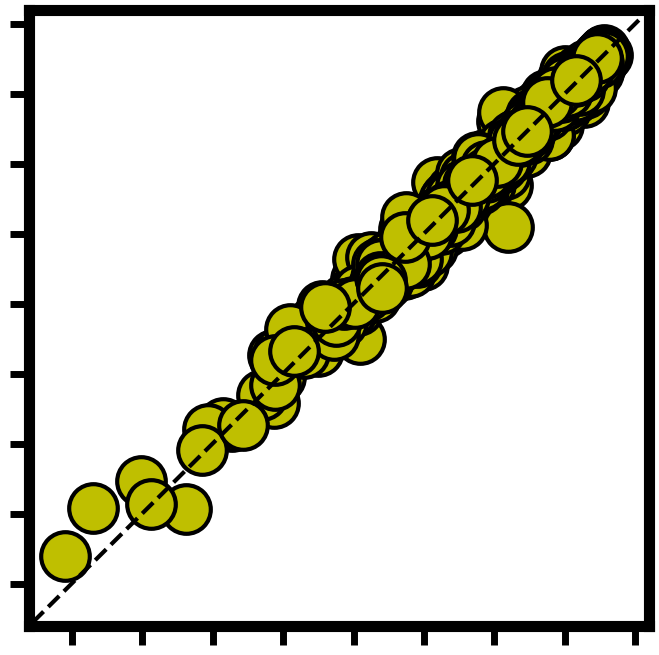

In [281]:
# plt.plot(data_y, data_yhat_GBR, 'o', label='GBRT', c='black', markersize='24', linewidth=2, markeredgecolor='k')
plt.plot(data_y, data_yhat_XGBR, 'o', label='Best model: XGBR', c='y', markersize='35', markeredgewidth=3, markeredgecolor='k')

# plt.title ('real vs predicted diffusivity',fontsize=25)
# plt.xlabel('simulation diffusivity log($D$)', fontsize=30)
# plt.ylabel('predicted diffusivity log($D$)',fontsize=30)
# plt.legend(loc='upper left', fontsize=35)

# p1 = max(max(data_y), max(data_y))
# p2 = min(min(data_y), min(data_y))
# plt.plot([p1, p2], [p1, p2],'b-' )
plt.plot([-50, 0], [-50, 0], '--', linewidth=3, color='black')

plt.ylim(-48, -4)
plt.xlim(-48, -4)

plt.tick_params(which='both', width=5)
plt.tick_params(which='major', length=14)
plt.tick_params(which='minor', length=4, color='r')
plt.rcParams["figure.figsize"] = (8,8)

plt.yticks(fontsize=30)
plt.xticks(fontsize=30)
plt.rcParams['axes.linewidth'] = 3

ax = plt.gca()
ax.axes.xaxis.set_ticklabels([])
ax.axes.yaxis.set_ticklabels([])

plt.savefig('XGBR.png', bbox_inches='tight')
plt.show()

# For small model figure

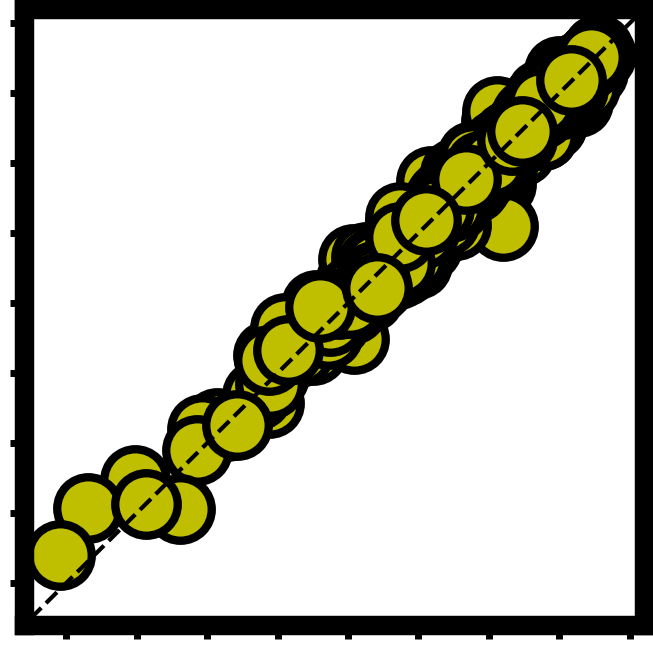

In [285]:
# plt.plot(data_y, data_yhat_GBR, 'o', label='GBRT', c='black', markersize='24', linewidth=2, markeredgecolor='k')
plt.plot(data_y, data_yhat_XGBR, 'o', label='Best model: XGBR', c='y', markersize='45', markeredgewidth=6, markeredgecolor='k')

# plt.title ('real vs predicted diffusivity',fontsize=25)
# plt.xlabel('simulation diffusivity log($D$)', fontsize=30)
# plt.ylabel('predicted diffusivity log($D$)',fontsize=30)
# plt.legend(loc='upper left', fontsize=35)

# p1 = max(max(data_y), max(data_y))
# p2 = min(min(data_y), min(data_y))
# plt.plot([p1, p2], [p1, p2],'b-' )
plt.plot([-50, 0], [-50, 0], '--', linewidth=3, color='black')

plt.ylim(-48, -4)
plt.xlim(-48, -4)

ax = plt.gca()
ax.axes.xaxis.set_ticklabels([])
ax.axes.yaxis.set_ticklabels([])

plt.tick_params(which='both', width=5)
plt.tick_params(which='major', length=10)
plt.tick_params(which='minor', length=4, color='r')
plt.rcParams["figure.figsize"] = (8,8)

plt.yticks(fontsize=30)
plt.xticks(fontsize=30)
plt.rcParams['axes.linewidth'] = 14

# plt.axis('off')



plt.savefig('small_XGBR.png', bbox_inches='tight')
plt.show()

## SHAP analysis

In [25]:
import shap

In [63]:
x = df2[['diameter',
    'mass',
    'ascentricF',
    'kdiameter',
    'ionicRad',
    'MetalNum',
    'MetalMass',
    'apertureAtom_σ',
    'e',
    'linker_length1', 'linker_length2', 'linker_length3',
    'linker_mass1', 'linker_mass2', 'linker_mass3',
    'func1_length', 'func2_length', 'func3_length', 
    'func1_mass', 'func2_mass', 'func3_mass']]

y= df2[['logD']]

In [64]:
X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size = 0.2)

In [65]:
XGBR.fit(X_train,Y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.4,
             early_stopping_rounds=None, enable_categorical=False, eta=0.45,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.449999988, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=4, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=200, n_jobs=2,
             num_parallel_tree=1, predictor='auto', random_state=60,
             reg_alpha=0, ...)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


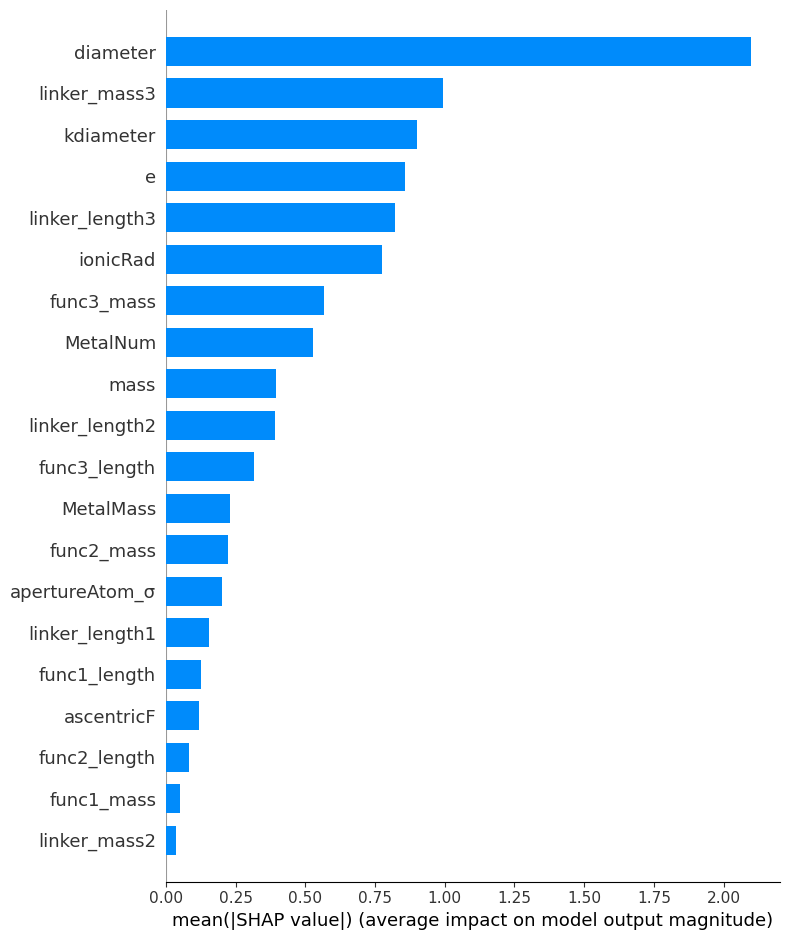

In [123]:
shap_values = shap.TreeExplainer(XGBR).shap_values(X_train)
shap.summary_plot(shap_values, X_train, plot_type='bar')

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


ValueError: Unable to determine Axes to steal space for Colorbar. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.

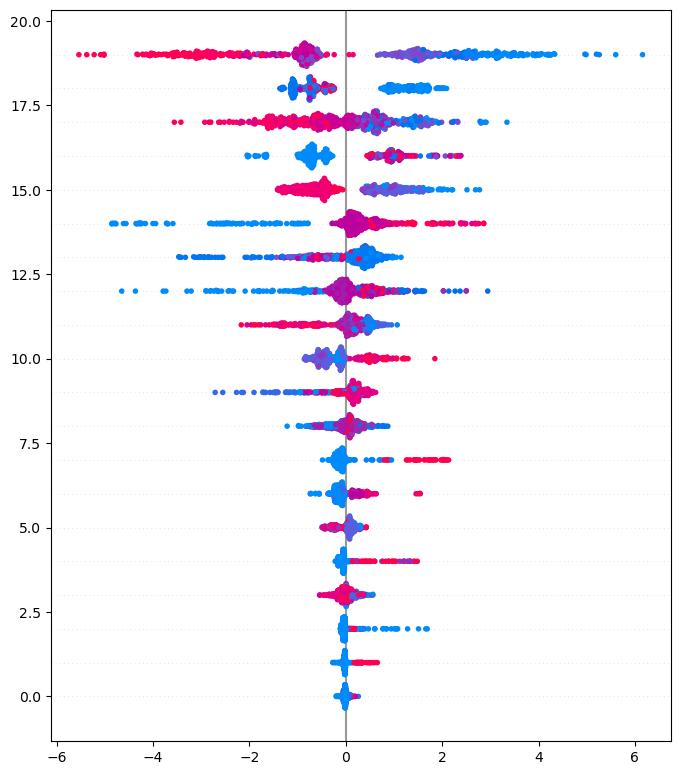

In [131]:
shap.summary_plot(shap_values, X_train)
# explainer = shap.Explainer(XGBR.predict, x40)
# shap_values = explainer(x)
# shap.summary_plot(shap_values)

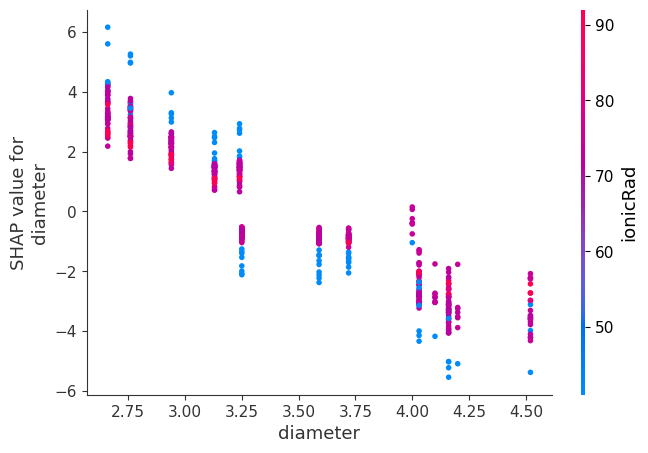

In [130]:
shap.dependence_plot("diameter", shap_values, X_train)

In [90]:
x40 = shap.utils.sample(x, 40)

explainer_ebm = shap.Explainer(XGBR.predict, x40)
shap_values_ebm = explainer_ebm(x)

Permutation explainer: 759it [00:26, 17.41it/s]                         


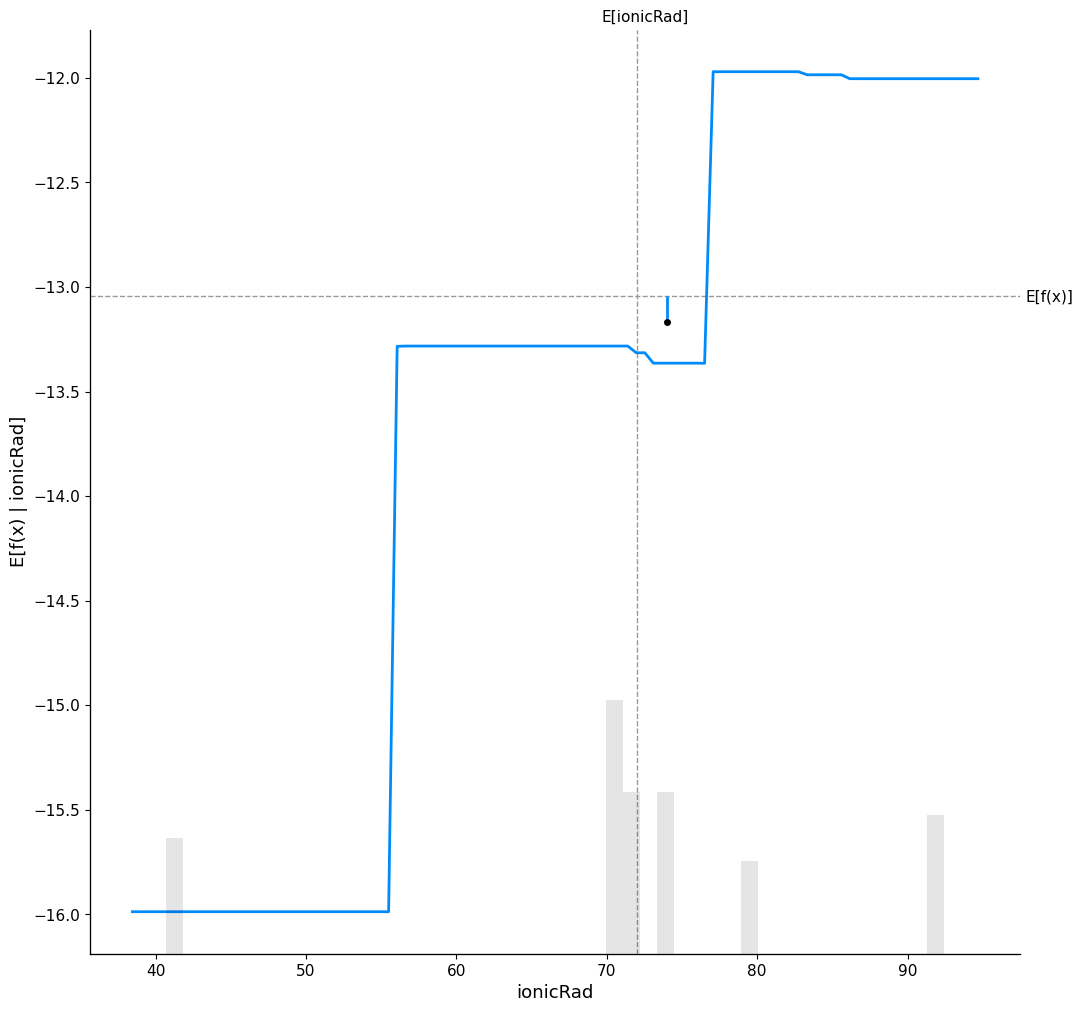

In [112]:
# make a standard partial dependence plot with a single SHAP value overlaid
sample_ind = 20
fig,ax = shap.partial_dependence_plot(
    "ionicRad", XGBR.predict, x40, model_expected_value=True,
    feature_expected_value=True, show=False, ice=False,
    shap_values=shap_values_ebm[sample_ind:sample_ind+1,:]
)

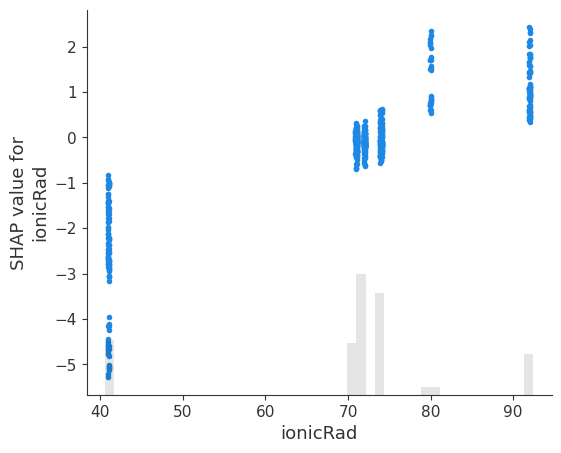

In [113]:
shap.plots.scatter(shap_values_ebm[:,"ionicRad"])

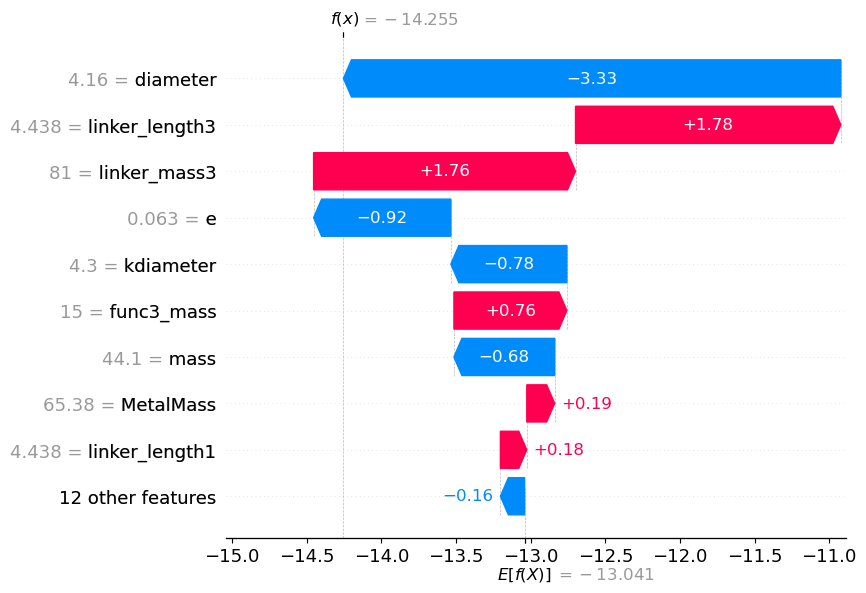

In [114]:
shap.plots.waterfall(shap_values_ebm[sample_ind])

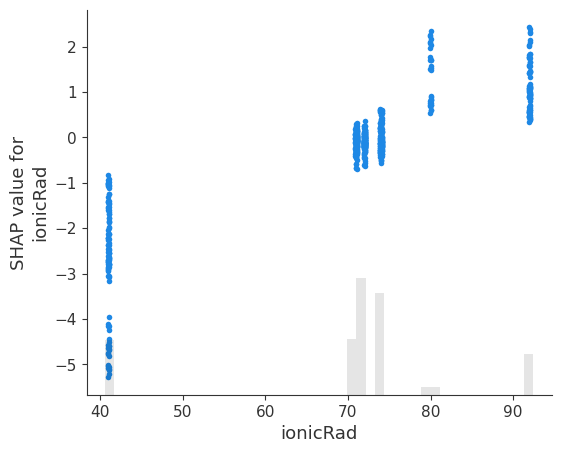

In [115]:
shap.plots.scatter(shap_values_ebm[:,"ionicRad"])

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


ValueError: Unable to determine Axes to steal space for Colorbar. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.

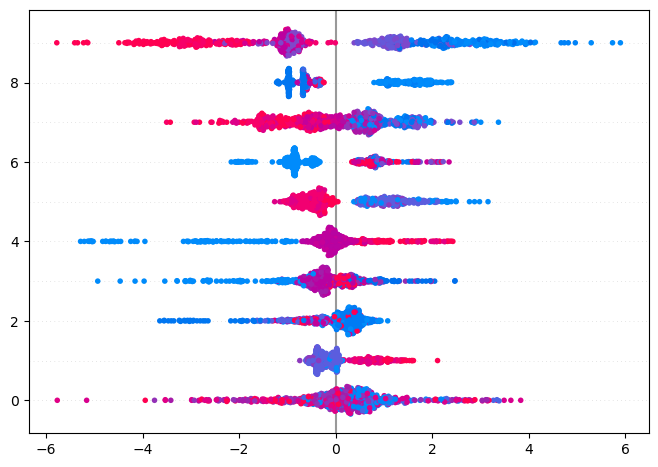

In [126]:
shap.plots.beeswarm(shap_values_ebm)

# Only Gaussian

In [16]:
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import accuracy_score

# Kernel definition
l = 2
sigma_f = 3
sigma_n = 1
# kernel = ConstantKernel(constant_value=sigma_f, constant_value_bounds=(1e-2, 1e5)) \
#             * RBF(length_scale=l, length_scale_bounds=(1e-2, 1e3))
kernel = RBF()
# GP model 
gpr = GaussianProcessRegressor(kernel=kernel, alpha=sigma_n**2, n_restarts_optimizer=10, )


# k-fold cross validation
data_y, data_yhat_tree, data_yhat_NN, data_yhat_regr, data_yhat_RF, data_yhat_GBR, data_yhat_XGBR, data_yhat_gpr = list(), list(), list(), list(), list(), list(), list(), list()
kfold = KFold(n_splits=10, shuffle=True, random_state=50)
# enumerate splits
for train_ix, test_ix in kfold.split(x):
    # get data
    train_X, test_X = x[train_ix], x[test_ix]
    train_y, test_y = y[train_ix], y[test_ix]

    gpr.fit(train_X, train_y.ravel())
    
    # make predictions
    yhat_gpr = gpr.predict(test_X)


    # store
    data_yhat_gpr.extend(yhat_gpr)

# evaluate the model

R2_gpr = (metrics.r2_score(data_y, data_yhat_gpr))
Med_ABS_er_gpr = (metrics.median_absolute_error(data_y, data_yhat_gpr))
Max_error_gpr = (metrics.max_error(data_y, data_yhat_gpr))
EV_gpr = (metrics.explained_variance_score(data_y, data_yhat_gpr))
Mean_abs_perc_error_gpr = (metrics.mean_absolute_percentage_error(data_y, data_yhat_gpr))
MSE_gpr = (metrics.mean_squared_error(data_y, data_yhat_gpr))

head = ["Model", "R2", "Med ABS error", "Max error", "explained variance", "Mean ABS perc error", "MSE" ]

results = [
           ["Gaussian Process Regressor", R2_gpr, Med_ABS_er_gpr, Max_error_gpr, EV_gpr, Mean_abs_perc_error_gpr, MSE_gpr],
          ]

print(tabulate(results, headers = head, tablefmt = "fancy_grid", floatfmt=".3f"))

ValueError: Found input variables with inconsistent numbers of samples: [0, 940]

In [17]:
X_train, X_test,\
    y_train, y_test = train_test_split(x, y,
                                       test_size=0.25,
                                       random_state=42)

In [73]:
from sklearn.metrics import roc_auc_score as ras
# create the squared exponential (RBF) kernel
from sklearn.gaussian_process.kernels import Matern
# kernel = 1*RBF(length_scale=1.0, length_scale_bounds=(1e-1, 1e1))+ ConstantKernel(constant_value=0.1)
# kernel = Matern(length_scale=0.5, nu=0.09)
kernel = DotProduct() + WhiteKernel()
  
# create the Gaussian process regressor with the RBF kernel
gp = GaussianProcessRegressor(kernel=kernel)
  
# fit the model to the data
gp.fit(X_train, y_train)
  
# make predictions on the test set
y_pred = gp.predict(X_test)
# ras(y_test, y_pred)
R2_gpr = (metrics.r2_score(y_test, y_pred))
R2_gpr

0.7515636673851802

## With scaling the data

In [50]:
scaler = StandardScaler()
scaler.fit(x)
x = scaler.transform(x)

In [79]:
shap.initjs()

# Write in a function
def shap_plot(j):
    explainerModel = shap.TreeExplainer(XGBR)
    shap_values_Model = explainerModel.shap_values(S)
    p = shap.force_plot(explainerModel.expected_value, shap_values_Model[j], S.iloc[[j]])
    return(p)

In [75]:
# Get the predictions and put them with the test data.
X_output = X_test.copy()
X_output.loc[:,'predict'] = np.round(XGBR.predict(X_output),2)

# Randomly pick some observations
random_picks = np.arange(1,130,10) # Every 10 rows
S = X_output.iloc[random_picks]
S

,diameter,mass,ascentricF,kdiameter,ionicRad,MetalNum,MetalMass,apertureAtom_σ,e,linker_length1,linker_length2,linker_length3,linker_mass1,linker_mass2,linker_mass3,func1_length,func2_length,func3_length,func1_mass,func2_mass,func3_mass,predict
195,3.24,44.010,0.225,3.30,80,25,54.938,0.250,0.0627,4.438,4.438,4.438,81.00,81.00,81.00,3.780,3.780,3.780,15.0,15.0,15.0,-8.440000
562,3.24,44.010,0.225,3.30,71,12,24.305,0.250,0.0627,4.438,4.438,5.996,81.00,81.00,117.00,3.780,3.780,2.278,15.0,15.0,1.0,-11.700000
405,3.13,28.000,0.037,3.64,72,27,58.930,0.325,0.7112,3.660,3.660,3.660,83.00,83.00,83.00,3.927,3.927,3.927,16.0,16.0,16.0,-8.190000
401,2.66,4.002,-0.390,2.60,72,27,58.930,0.325,0.7112,3.660,3.660,3.660,83.00,83.00,83.00,3.927,3.927,3.927,16.0,16.0,16.0,-7.150000
379,4.16,44.100,0.152,4.30,72,27,58.930,0.250,0.0627,4.438,4.438,5.996,81.00,81.00,117.00,3.780,3.780,4.250,15.0,15.0,126.9,-25.059999
586,4.03,42.080,0.142,4.50,71,12,24.305,0.250,0.0627,4.438,4.438,5.996,81.00,81.00,117.00,3.780,3.780,4.250,15.0,15.0,126.9,-15.730000
706,3.72,30.070,0.099,4.00,71,29,63.456,0.285,0.2550,4.860,4.860,4.860,101.98,101.98,101.98,3.780,3.780,3.780,15.0,15.0,15.0,-11.530000
363,2.94,31.999,0.022,3.46,92,48,112.411,0.250,0.0627,4.438,4.438,5.996,81.00,81.00,117.00,3.780,3.780,4.250,15.0,15.0,126.9,-11.610000
611,3.24,44.010,0.225,3.30,41,4,9.012,0.400,1.8731,6.010,6.010,6.010,223.80,223.80,223.80,3.780,3.780,3.780,15.0,15.0,15.0,-9.600000
368,3.72,30.070,0.099,4.00,92,48,112.411,0.250,0.0627,4.438,4.438,5.996,81.00,81.00,117.00,3.780,3.780,4.250,15.0,15.0,126.9,-17.230000


In [83]:
shap_plot(1)

ValueError: This reshape error is often caused by passing a bad data matrix to SHAP. See https://github.com/slundberg/shap/issues/580

In [56]:
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import accuracy_score

start_time = time.time()

XGBR = XGBRegressor(n_estimators=200, max_depth=5, eta=0.45, subsample=0.8, colsample_bytree=0.7,n_jobs=4, random_state=20
                   )
RF = RandomForestRegressor(n_estimators=200, max_depth=5, random_state=1)
GBR = GradientBoostingRegressor(n_estimators=200, learning_rate=0.2, max_depth=5, random_state=0,loss='squared_error')
NNregr = MLPRegressor(hidden_layer_sizes=(40, 30, 20, 15, 10), solver='lbfgs', random_state=1, max_iter=4600)
tree=DecisionTreeRegressor(max_depth=6,random_state=1)
# regr=LinearRegression()
regr = linear_model.LinearRegression()
kernel = DotProduct() + WhiteKernel()
gpr = GaussianProcessRegressor(kernel=kernel, random_state=0)

# k-fold cross validation
data_y, data_yhat_tree, data_yhat_NN, data_yhat_regr, data_yhat_RF, data_yhat_GBR, data_yhat_XGBR = list(), list(), list(), list(), list(), list(), list()
kfold = KFold(n_splits=5, shuffle=True, random_state=None)
# enumerate splits
for i in range(5):
    for train_ix, test_ix in kfold.split(x):
        # get data
        train_X, test_X = x[train_ix], x[test_ix]
        train_y, test_y = y[train_ix], y[test_ix]

        XGBR.fit(train_X, train_y.ravel())
        RF.fit(train_X, train_y.ravel())
        GBR.fit(train_X, train_y.ravel())
        NNregr.fit(train_X, train_y.ravel())
        tree.fit(train_X, train_y)
        regr.fit(train_X, train_y)
    
        # make predictions
        yhat_tree = tree.predict(test_X)
        yhat_regr = regr.predict(test_X)
        yhat_XGBR = XGBR.predict(test_X)
        yhat_RF = RF.predict(test_X)
        yhat_GBR = GBR.predict(test_X)
        yhat_NNregr = NNregr.predict(test_X)

        # store
        data_y.extend(test_y)
        data_yhat_tree.extend(yhat_tree)
        data_yhat_regr.extend(yhat_regr)
        data_yhat_XGBR.extend(yhat_XGBR)
        data_yhat_RF.extend(yhat_RF)
        data_yhat_GBR.extend(yhat_GBR)
        data_yhat_NN.extend(yhat_NNregr)
# evaluate the model

R2_RF = (metrics.r2_score(data_y, data_yhat_RF))
Med_ABS_er_RF = (metrics.median_absolute_error(data_y, data_yhat_RF))
Max_error_RF = (metrics.max_error(data_y, data_yhat_RF))
EV_RF = (metrics.explained_variance_score(data_y, data_yhat_RF))
Mean_abs_perc_error_RF = (metrics.mean_absolute_percentage_error(data_y, data_yhat_RF))
MSE_RF = (metrics.mean_squared_error(data_y, data_yhat_RF))

R2_GBR = (metrics.r2_score(data_y, data_yhat_GBR))
Med_ABS_er_GBR = (metrics.median_absolute_error(data_y, data_yhat_GBR))
Max_error_GBR = (metrics.max_error(data_y, data_yhat_GBR))
EV_GBR = (metrics.explained_variance_score(data_y, data_yhat_GBR))
Mean_abs_perc_error_GBR = (metrics.mean_absolute_percentage_error(data_y, data_yhat_GBR))
MSE_GBR = (metrics.mean_squared_error(data_y, data_yhat_GBR))

R2_XGBR = (metrics.r2_score(data_y, data_yhat_XGBR))
Med_ABS_er_XGBR = (metrics.median_absolute_error(data_y, data_yhat_XGBR))
Max_error_XGBR = (metrics.max_error(data_y, data_yhat_XGBR))
EV_XGBR = (metrics.explained_variance_score(data_y, data_yhat_XGBR))
Mean_abs_perc_error_XGBR = (metrics.mean_absolute_percentage_error(data_y, data_yhat_XGBR))
MSE_XGBR = (metrics.mean_squared_error(data_y, data_yhat_XGBR))

R2_NN = (metrics.r2_score(data_y, data_yhat_NN))
Med_ABS_er_NN = (metrics.median_absolute_error(data_y, data_yhat_NN))
Max_error_NN = (metrics.max_error(data_y, data_yhat_NN))
EV_NN = (explained_variance_score(data_y, data_yhat_NN))
Mean_abs_perc_error_NN = (metrics.mean_absolute_percentage_error(data_y, data_yhat_NN))
MSE_NN = (metrics.mean_squared_error(data_y, data_yhat_NN))

R2_regr = (metrics.r2_score(data_y, data_yhat_regr))
Med_ABS_er_regr = (metrics.median_absolute_error(data_y, data_yhat_regr))
Max_error_regr = (metrics.max_error(data_y, data_yhat_regr))
EV_regr = (metrics.explained_variance_score(data_y, data_yhat_regr))
Mean_abs_perc_error_regr = (metrics.mean_absolute_percentage_error(data_y, data_yhat_regr))
MSE_regr = (metrics.mean_squared_error(data_y, data_yhat_regr))

R2_DT = (metrics.r2_score(data_y, data_yhat_tree))
Med_ABS_er_DT = (metrics.median_absolute_error(data_y, data_yhat_tree))
Max_error_DT = (metrics.max_error(data_y, data_yhat_tree))
EV_DT = (metrics.explained_variance_score(data_y, data_yhat_tree))
Mean_abs_perc_error_DT = (metrics.mean_absolute_percentage_error(data_y, data_yhat_tree))
MSE_DT = (metrics.mean_squared_error(data_y, data_yhat_tree))

head = ["Model", "R2", "Med ABS error", "Max error", "explained variance", "Mean ABS perc error", "MSE" ]

results = [
           ["Decision tree", R2_DT, Med_ABS_er_DT, Max_error_DT, EV_DT, Mean_abs_perc_error_DT, MSE_DT],
           ["Regression", R2_regr, Med_ABS_er_regr, Max_error_regr, EV_regr, Mean_abs_perc_error_regr, MSE_regr],
           ["Random Forest", R2_RF, Med_ABS_er_RF, Max_error_RF, EV_RF, Mean_abs_perc_error_RF, MSE_RF],
           ["Gradient Tree Boosting", R2_GBR, Med_ABS_er_GBR, Max_error_GBR, EV_GBR, Mean_abs_perc_error_GBR, MSE_GBR],
           ["Extreme Gradient Boosting", R2_XGBR, Med_ABS_er_XGBR, Max_error_XGBR, EV_XGBR, Mean_abs_perc_error_XGBR, MSE_XGBR],
           ["Neural Network", R2_NN, Med_ABS_er_NN, Max_error_NN, EV_NN, Mean_abs_perc_error_NN, MSE_NN]]

print(tabulate(results, headers = head, tablefmt = "fancy_grid", floatfmt=".3f"))
print("--- %s minutes ---" % ((time.time() - start_time)/60))

c:\Users\pkrok\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\Users\pkrok\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\Users\pkrok\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITE

╒═══════════════════════════╤═══════╤═════════════════╤═════════════╤══════════════════════╤═══════════════════════╤═══════╕
│ Model                     │    R2 │   Med ABS error │   Max error │   explained variance │   Mean ABS perc error │   MSE │
╞═══════════════════════════╪═══════╪═════════════════╪═════════════╪══════════════════════╪═══════════════════════╪═══════╡
│ Decision tree             │ 0.885 │           0.732 │      13.824 │                0.885 │                 0.085 │ 3.719 │
├───────────────────────────┼───────┼─────────────────┼─────────────┼──────────────────────┼───────────────────────┼───────┤
│ Regression                │ 0.761 │           1.672 │      19.198 │                0.761 │                 0.165 │ 7.759 │
├───────────────────────────┼───────┼─────────────────┼─────────────┼──────────────────────┼───────────────────────┼───────┤
│ Random Forest             │ 0.897 │           0.777 │       9.628 │                0.897 │                 0.084 │ 3.334 │


c:\Users\pkrok\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


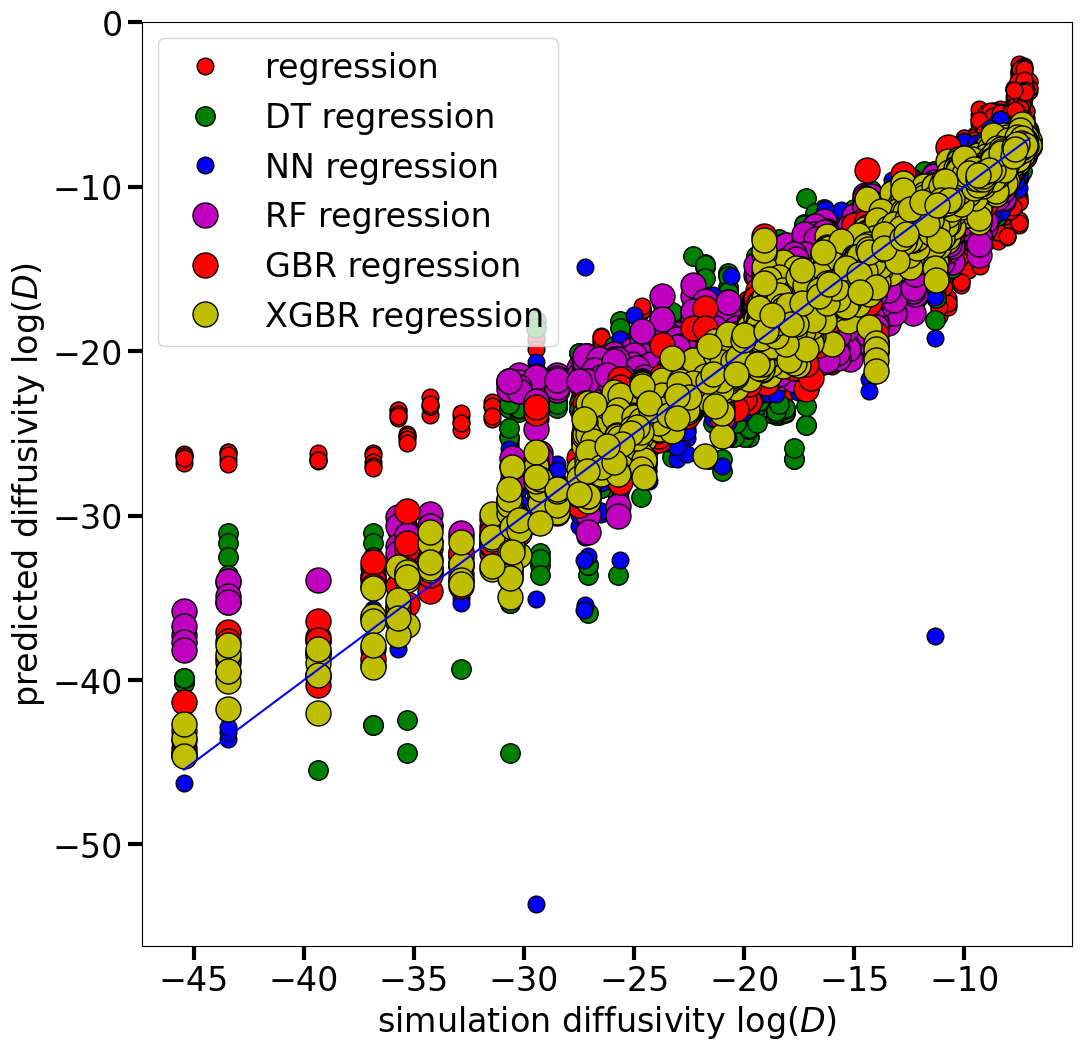

In [57]:
plt.plot(data_y, data_yhat_regr, 'o', label='regression', c='r', markersize='12', linewidth=3, markeredgecolor='k')
plt.plot(data_y, data_yhat_tree, 'o', label='DT regression', c='g', markersize='14', linewidth=3, markeredgecolor='k')
plt.plot(data_y, data_yhat_NN, 'o', label='NN regression', c='b', markersize='12', linewidth=3, markeredgecolor='k')
plt.plot(data_y, data_yhat_RF, 'o', label='RF regression', c='m', markersize='18', linewidth=3, markeredgecolor='k')
plt.plot(data_y, data_yhat_GBR, 'o', label='GBR regression', c='r', markersize='18', linewidth=3, markeredgecolor='k')
plt.plot(data_y, data_yhat_XGBR, 'o', label='XGBR regression', c='y', markersize='18', linewidth=3, markeredgecolor='k')

# plt.title ('real vs predicted diffusivity',fontsize=25)
plt.xlabel('simulation diffusivity log($D$)', fontsize=24)
plt.ylabel('predicted diffusivity log($D$)',fontsize=24)
plt.legend(loc='upper left', fontsize=24)

p1 = max(max(data_y), max(data_y))
p2 = min(min(data_y), min(data_y))
plt.plot([p1, p2], [p1, p2],'b-' )

# plt.ylim(1.5, 5)
# plt.xlim(1.5, 5)

plt.tick_params(which='both', width=3)
plt.tick_params(which='major', length=10)
plt.tick_params(which='minor', length=4, color='r')
plt.rcParams["figure.figsize"] = (12,12)

plt.yticks(fontsize=24)
plt.xticks(fontsize=24)

plt.savefig('D_all_models.png', bbox_inches='tight')
plt.show()

In [54]:
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import accuracy_score

XGBR = XGBRegressor(n_estimators=200, max_depth=5, eta=0.45, subsample=0.8, colsample_bytree=0.7,n_jobs=4, random_state=20
                   )
GBR = GradientBoostingRegressor(n_estimators=200, learning_rate=0.2, max_depth=5, random_state=10,loss='squared_error')

# k-fold cross validation
data_y, data_yhat_tree, data_yhat_NN, data_yhat_regr, data_yhat_RF, data_yhat_GBR, data_yhat_XGBR, data_yhat_gpr = list(), list(), list(), list(), list(), list(), list(), list()
kfold = KFold(n_splits=5, shuffle=True, random_state=50)
# enumerate splits
for train_ix, test_ix in kfold.split(x):
    # get data
    train_X, test_X = x[train_ix], x[test_ix]
    train_y, test_y = y[train_ix], y[test_ix]

    XGBR.fit(train_X, train_y.ravel())
    GBR.fit(train_X, train_y.ravel())
    
    # make predictions
    yhat_XGBR = XGBR.predict(test_X)
    yhat_GBR = GBR.predict(test_X)

    # store
    data_y.extend(test_y)
    data_yhat_XGBR.extend(yhat_XGBR)
    data_yhat_GBR.extend(yhat_GBR)

# evaluate the model

R2_GBR = (metrics.r2_score(data_y, data_yhat_GBR))
Med_ABS_er_GBR = (metrics.median_absolute_error(data_y, data_yhat_GBR))
Max_error_GBR = (metrics.max_error(data_y, data_yhat_GBR))
EV_GBR = (metrics.explained_variance_score(data_y, data_yhat_GBR))
Mean_abs_perc_error_GBR = (metrics.mean_absolute_percentage_error(data_y, data_yhat_GBR))
MSE_GBR = (metrics.mean_squared_error(data_y, data_yhat_GBR))

R2_XGBR = (metrics.r2_score(data_y, data_yhat_XGBR))
Med_ABS_er_XGBR = (metrics.median_absolute_error(data_y, data_yhat_XGBR))
Max_error_XGBR = (metrics.max_error(data_y, data_yhat_XGBR))
EV_XGBR = (metrics.explained_variance_score(data_y, data_yhat_XGBR))
Mean_abs_perc_error_XGBR = (metrics.mean_absolute_percentage_error(data_y, data_yhat_XGBR))
MSE_XGBR = (metrics.mean_squared_error(data_y, data_yhat_XGBR))


head = ["Model", "R2", "Med ABS error", "Max error", "explained variance", "Mean ABS perc error", "MSE" ]

results = [
           ["Gradient Tree Boosting", R2_GBR, Med_ABS_er_GBR, Max_error_GBR, EV_GBR, Mean_abs_perc_error_GBR, MSE_GBR],
           ["Extreme Gradient Boosting", R2_XGBR, Med_ABS_er_XGBR, Max_error_XGBR, EV_XGBR, Mean_abs_perc_error_XGBR, MSE_XGBR],
          ]

print(tabulate(results, headers = head, tablefmt = "fancy_grid", floatfmt=".3f"))

╒═══════════════════════════╤═══════╤═════════════════╤═════════════╤══════════════════════╤═══════════════════════╤═══════╕
│ Model                     │    R2 │   Med ABS error │   Max error │   explained variance │   Mean ABS perc error │   MSE │
╞═══════════════════════════╪═══════╪═════════════════╪═════════════╪══════════════════════╪═══════════════════════╪═══════╡
│ Gradient Tree Boosting    │ 0.979 │           0.291 │       5.656 │                0.979 │                 0.036 │ 0.681 │
├───────────────────────────┼───────┼─────────────────┼─────────────┼──────────────────────┼───────────────────────┼───────┤
│ Extreme Gradient Boosting │ 0.974 │           0.345 │       5.178 │                0.974 │                 0.043 │ 0.831 │
╘═══════════════════════════╧═══════╧═════════════════╧═════════════╧══════════════════════╧═══════════════════════╧═══════╛


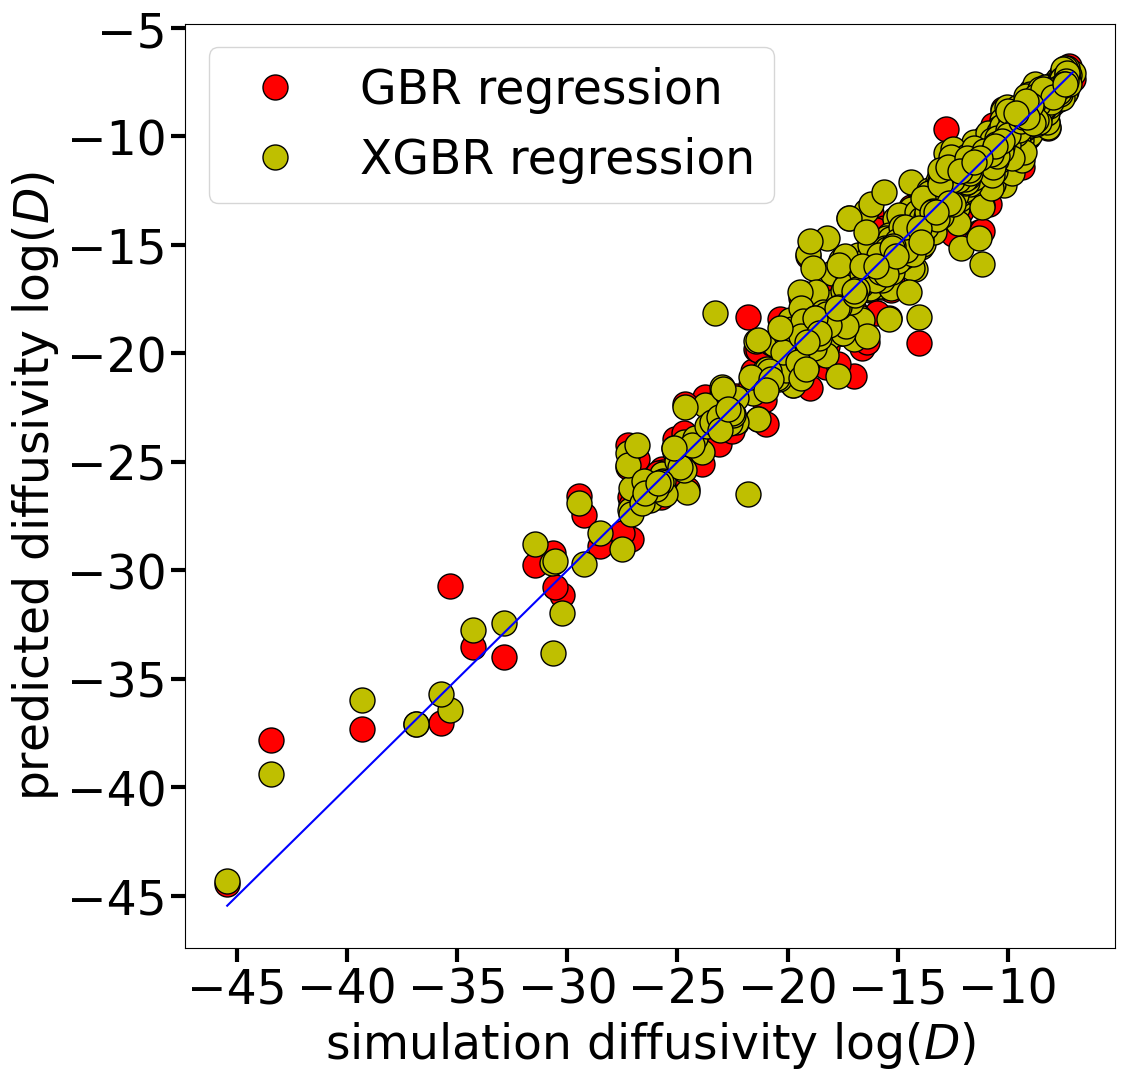

In [55]:
plt.plot(data_y, data_yhat_GBR, 'o', label='GBR regression', c='r', markersize='18', linewidth=3, markeredgecolor='k')
plt.plot(data_y, data_yhat_XGBR, 'o', label='XGBR regression', c='y', markersize='18', linewidth=3, markeredgecolor='k')

# plt.title ('real vs predicted diffusivity',fontsize=25)
plt.xlabel('simulation diffusivity log($D$)', fontsize=34)
plt.ylabel('predicted diffusivity log($D$)',fontsize=34)
plt.legend(loc='upper left', fontsize=34)

p1 = max(max(data_y), max(data_y))
p2 = min(min(data_y), min(data_y))
plt.plot([p1, p2], [p1, p2],'b-' )

# plt.ylim(1.5, 5)
# plt.xlim(1.5, 5)

plt.tick_params(which='both', width=3)
plt.tick_params(which='major', length=10)
plt.tick_params(which='minor', length=4, color='r')
plt.rcParams["figure.figsize"] = (12,12)

plt.yticks(fontsize=34)
plt.xticks(fontsize=34)

plt.savefig('XGBR.png', bbox_inches='tight')
plt.show()